# Derivative Analytics Library

## Background Environment Setup

In [1]:
import numpy as np
import datetime as dt
import pandas as pd
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d
%matplotlib inline

In [2]:
def get_YearDelta(date, day_count=365):
    # return a ndarray contains day deltas in year
    # Parameter:
    '''
    date (array of datetime)
    day_count(float): number of days for a year
    '''
    YearDelta = [(x-date[0]).days/day_count for x in date]
    return np.array(YearDelta)

In [3]:
# test get_YearDelta function with 2016/1/1, 2016/4/1, 2016/7/1, 2016/10/1
date = [dt.datetime(2016,1,1),dt.datetime(2016,4,1),dt.datetime(2016,7,1),dt.datetime(2016,10,1)]
get_YearDelta(date)

array([ 0.        ,  0.24931507,  0.49863014,  0.75068493])

### Short Curve Class

In [4]:
class const_rate(object):
    # a const_rate class 
    # Attribute:
    '''
    name (string): name of the instance
    short_rate (float): the constant short rate
    '''
    def __init__(self, name, short_rate):
        # default initialization
        self.name=name
        self.short_rate=short_rate
        
    def get_discount_factor(self, date, dttype=True):
        # return an array of discount factor along with days delta in a row
        if dttype is True:
            dlist=get_YearDelta(date)
        else:
            dlist=date
        dflist = np.exp(self.short_rate*np.sort(-dlist))
        return np.array((date,dflist)).T      

In [5]:
# Test the const_rate class
conrate = const_rate('conrate', 0.05)
conrate.get_discount_factor(date)

array([[datetime.datetime(2016, 1, 1, 0, 0), 0.96316143217545],
       [datetime.datetime(2016, 4, 1, 0, 0), 0.9753767163648953],
       [datetime.datetime(2016, 7, 1, 0, 0), 0.9876116222305686],
       [datetime.datetime(2016, 10, 1, 0, 0), 1.0]], dtype=object)

In [6]:
class nonconst_rate(object):
    # a nonconst_rate class takes two sequence as rate and time
    # Attribute:
    '''
    name (string): name of the instance
    short_rate (ndarray): the array of short rate
    date (ndarray): the array of the date
    '''
    def __init__(self, name, short_rate, date):
        # default initialization
        self.name=name
        self.short_rate=short_rate
        self.date = date
    
    def get_discount_factor(self,dttype=True):
        if dttype is True:
            dlist = get_YearDelta(self.date)
        else:
            dlist = np.array(self.date)
        dflist = np.exp(self.short_rate*np.sort(-dlist))
        return np.array((date,dflist)).T   
    
    def get_interp_graph(self):
        time = get_YearDelta(self.date)
        rate = self.short_rate
        f = interp1d(time,rate,kind = 'cubic')
        xnew = np.linspace(0.,np.max(time), num=40, endpoint=True)
        fig = plt.plot(xnew,f(xnew),'-',linewidth=0.5)
        plt.plot(time,rate,'ro')
        plt.plot(time,rate,'--',linewidth=0.5)
        plt.legend(['cubic','data'],loc='best')
        return fig

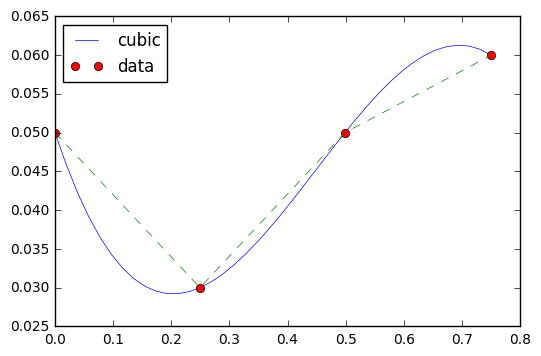

In [7]:
# Test the nonconst_rate class
short = np.array([0.05,0.03,0.05,0.06])
rate = nonconst_rate('rate',short, date)
rate.get_discount_factor()
fig = rate.get_interp_graph()

### Market Environment 

In [8]:
class mar_env(object):
    # a class holder for relative market environment 
    # attributes:
    '''
    name (string): object name
    pricing_date (datetime): date of the market environment
    constants (dictionary): model parameter such as volatility, risk free rate, etc. It can be a single object or an array
    lists (dictionary): list of risky securities, such as stock etc
    curves (dictionary): used to hold discounting cruve
    '''
    # methods:
    def __init__(self, name, price_date):
        self.name = name
        self.price_date = price_date
        self.constants={}
        self.lists={}
        self.curves={}
        
    def add_constants(self,key,constant):
        # constats as an attribute can be used to hold constant parameters.
        self.constants[key] = constant    
    def get_constants(self,key):
        return self.constants[key]
    
    def add_lists(self, key, list_object):
        # lists as an attribute can be used to hold securities.
        self.lists[key] = list_object        
    def get_lists(self, key):
        return self.lists[key]
    
    def add_curves(self, key, curve):
        # curves as an attribute can be used to hold short rate object.
        self.curves[key] = curve        
    def get_curves(self,key):
        return self.curves[key]
    
    def add_env(self, env):
        for key in env.constants:
            self.constants[key] = env.constants[key]
        for key in env.lists:
            self.lists[key] = env.lists[key]
        for key in env.curves:
            self.curves[key] = env.curves[key]
    
    def print_env(self):
        # print out all relevant market environment information
        print(self.name, '(Pricing Date: ', self.price_date, ')\n')
        print('constants:')
        print(self.constants, '\n')
        print('lists: ')
        print(self.lists, '\n')
        print('curves: ')
        print(self.curves)
        

In [9]:
# test market objects
market1 = mar_env('market1', dt.datetime(2015,1,1))
market1.add_lists('symbols', ['AAPL','MSFT','FB'])
market1.add_lists('symbols2',['NFLX','MS','GS'])
market1.add_curves('short_rate',rate)
market1.add_constants('volatility',0.3)
market1.add_constants('riskfree', 0)
market1.print_env()

market1 (Pricing Date:  2015-01-01 00:00:00 )

constants:
{'riskfree': 0, 'volatility': 0.3} 

lists: 
{'symbols2': ['NFLX', 'MS', 'GS'], 'symbols': ['AAPL', 'MSFT', 'FB']} 

curves: 
{'short_rate': <__main__.nonconst_rate object at 0x10952ec50>}


## Simulation

In [10]:
def sn_generator(dim, antithetic = True, moment_matching = True, fixed_seed = False):
    # Used to generate random number with input dimension
    # Parameters:
    '''
    dim (tuple): 3 dim tuple that defines the dimension of the random number
    antithetic: True if antithetic variance deduction method is applied
    moment_matching: True if moment_matchign variance deduction method is applied
    '''
    if fixed_seed is True:
        np.random.seed(10)
    if antithetic is True:
        rn = np.random.standard_normal((dim[0],dim[1],dim[2]/2))
        rn = np.concatenate((rn,-rn),axis=2)
    else:
        rn = np.random.standard_normal(dim)
    if moment_matching is True:
        rn = rn-np.mean(rn)
        rn = rn/np.std(rn)
    if dim[0] ==1:
        return rn[0]
    else:
        return rn

In [11]:
# Test sn_generator
snrn = sn_generator((3,4,4),antithetic=False,moment_matching=False,fixed_seed=True)
print('random number generated: ')
print(snrn)
print('mean: ', snrn.mean())
print('std: ', snrn.std())

random number generated: 
[[[ 1.3315865   0.71527897 -1.54540029 -0.00838385]
  [ 0.62133597 -0.72008556  0.26551159  0.10854853]
  [ 0.00429143 -0.17460021  0.43302619  1.20303737]
  [-0.96506567  1.02827408  0.22863013  0.44513761]]

 [[-1.13660221  0.13513688  1.484537   -1.07980489]
  [-1.97772828 -1.7433723   0.26607016  2.38496733]
  [ 1.12369125  1.67262221  0.09914922  1.39799638]
  [-0.27124799  0.61320418 -0.26731719 -0.54930901]]

 [[ 0.1327083  -0.47614201  1.30847308  0.19501328]
  [ 0.40020999 -0.33763234  1.25647226 -0.7319695 ]
  [ 0.66023155 -0.35087189 -0.93943336 -0.48933722]
  [-0.80459114 -0.21269764 -0.33914025  0.31216994]]]
mean:  0.0980537207591
std:  0.916390229175


In [12]:
class simulation_class(object):
    # attributes:
    '''
    name (string): class name
    mar_env (object): instance of market_environment
    corr (boolean): True if correlated with other model object
    '''
    
    '''
    Madatory parameter that should be passed from the mar_env class:
     price date, 
     from constants attribute: final_date, frequency, volatility, initial_value, paths
     from curves attribuet: discoung_curve
     
    Optional parameter that should be passed from the mar_env class:
     from lists attribute: 
        time_grid, cholesky_matrix, rn_set, random_nember
     
    '''
    # methods:
    def __init__(self, name, mar_env, corr=False):
        try:
            self.name = name
            self.price_date = mar_env.price_date
            self.final_date = mar_env.get_constants('final_date')
            self.frequency = mar_env.get_constants('frequency')
            self.volatility = mar_env.get_constants('volatility')
            self.initial_value = mar_env.get_constants('initial_value')
            self.discount_curve = mar_env.get_curves('discount_curve')
            self.paths =  mar_env.get_constants('paths')
            self.correlated = corr
            if corr is True:
                self.cholesky_matrix = mar_env.get_lists('cholesky_matrix')
                self.rn_set = mar_env.get_lists('rn_set')[self.name]
                self.random_numbers = mar_env.get_lists('random_numbers')
            try:
                self.time_grid = mar_env.get_lists('time_grid')
            except:
                self.time_grid=None
        except:
            print('Necessary information missing')
    
    def time_grid_generator(self):
        # it generate a equally intervaled time grid for simulation.
        # one thing should be noted is that it this function didn't return anything
        start = self.price_date
        end = self.final_date
        time_grid=pd.date_range(start=start, end=end,freq=self.frequency).to_pydatetime()
        time_grid=list(time_grid)
        self.time_grid = np.array(time_grid)
    
    
    def get_instrument_values(self, fixed_seed = True):
        self.generate_paths(fixed_seed = fixed_seed, day_count=365)
        return self.instrument_values     
    
    def get_hist(self):
        plt.hist(self.instrument_values[-1],bins=50)
        plt.xlabel('final value')
        plt.ylabel('frequency')
        plt.grid(True)
        plt.title('Final value for simulation')

### Geometric Brownian Motion

In [13]:
class geometric_brownian_motion(simulation_class):
    # a sub clas inheritated from the simulaiton_class
    # attribute:
    '''
    name (string): name of the object
    mar_env(object): instantce of market environment
    corr (Boolean): wheter correlated with other simulation
    '''
    # method:
    def __init__(self, name, mar_env,corr=False):
        # No additional information needed other than information from simulation_class
        super(geometric_brownian_motion, self).__init__(name, mar_env, corr)
    
    def update(self, initial_value=None, volatility=None, final_date=None, price_date = None):
        # update the main attribute for the GBM simulation
        if initial_value is not None:
            self.initial_value = initial_value
        if volatility is not None:
            self.volatility = volatility
        if final_date is not None:
            self.final_date = final_date
        if price_date is not None:
            self.price_date = price_date
        self.instrument_value=None
    
    def generate_paths(self, fixed_seed = False, day_count=365.):
        if self.time_grid is None:
            self.time_grid_generator()
        M = len(self.time_grid)  # time interval
        N = self.paths           # number of simulation path
        paths = np.zeros((M,N))
        paths[0] = self.initial_value
        if not self.correlated:
            rand = sn_generator((1,M,N),fixed_seed=fixed_seed)
        else:
            rand = self.random_numbers
        shor_rate = self.discount_curve.short_rate
        for t in range(1, len(self.time_grid)):
            if not self.correlated:
                ran = rand[t]
            else:
                ran = np.dot(self.cholesky_matrix, rand[:,t,:])
                ran = ran[self.rn_set]
            dt = (self.time_grid[t]-self.time_grid[t-1]).days/day_count
            paths[t] = paths[t-1]*np.exp((self.discount_curve.short_rate - 0.5*self.volatility**2)*dt+self.volatility*np.sqrt(dt)*ran)
        self.instrument_values = paths    

/usr/local/lib/python3.5/site-packages/ipykernel/__main__.py:12: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(array([ 735995.,  736024.,  736055.,  736085.,  736116.,  736146.,
         736177.,  736208.,  736238.,  736269.,  736299.]),
 <a list of 11 Text xticklabel objects>)

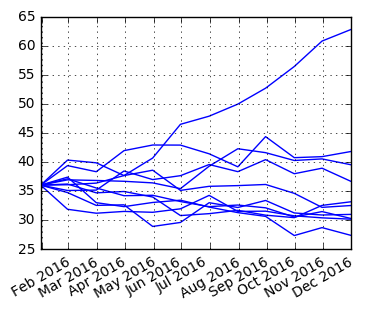

In [14]:
# Test GBM simulation
mar_env = mar_env('mar_env',dt.datetime(2016,1,1))
mar_env.add_constants('initial_value', 36.)
mar_env.add_constants('volatility',0.2)
mar_env.add_constants('final_date', dt.datetime(2016,12,31))
mar_env.add_constants('frequency','M')
mar_env.add_constants('paths', 10000)
csr = const_rate('csr', 0.05)
mar_env.add_curves('discount_curve', csr)
gbm = geometric_brownian_motion('gbm', mar_env)
gbm.time_grid_generator()
paths1 = gbm.get_instrument_values()
plt.figure(figsize=(4,3))
plt.plot(gbm.time_grid,paths1[:, :10],'b')
plt.grid(True)
plt.xticks(rotation=30)

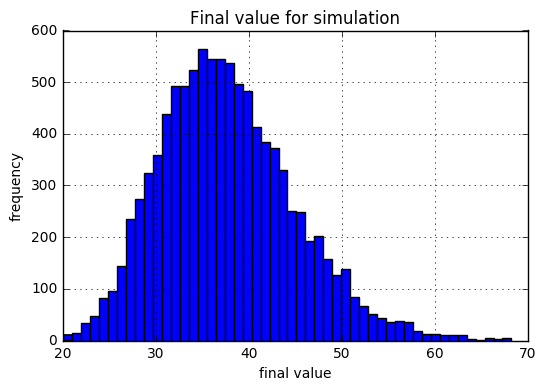

In [15]:
gbm.get_hist()

### Jump Diffusion

### Mean Reverting

## Derivative Valuation

In [16]:
class valuation_class(object):
    # generic class for single factor valuation model
    # attribtue:
    '''
    name (string): name of the object
    underlying (object): instance of simulation class
    mar_env (object): instance of market environment
    payoff_func(string): payoff function at maturity
    '''
    '''
    mandatory parameter should inherited from mar_env:
     from constant: maturity
     from attribute: maturity date, frequency, discount_curve
    optional parameter:
     strike (only for option)
    '''
    # method
    
    def __init__(self, name, underlying, mar_env, payoff_func=''):
        try:
            self.name=name
            self.price_date = mar_env.price_date
            self.maturity=mar_env.get_constants('maturity')
            self.frequency=underlying.frequency
            self.paths = underlying.paths
            self.discount_curve = underlying.discount_curve
            self.payoff_func = payoff_func
            self.underlying = underlying
            try:
                self.strike=mar_env.get_constants('strike')
            except:
                pass
        except:
            print('Extra necessary information needed')
            
    def update(self, initial_value=None, volatility=None, strike = None, maturity=None):
        if initial_value is not None:
            self.underlying.update(initial_value = initial_value)
        if volatility is not None:
            self.underlying.update(volatility = volatility)
        if strike is not None:
            self.strike = strike
        if maturity is not None:
            self.maturity = maturity
            if not maturity in self.underlying.time_grid:
                self.underlying.special_dates.append(maturity)
        self.underlying.instrument_values = None
        
        
    def delta(self,interval=None):
        if interval is None:
            interval = self.underlying.initial_value/50.
        value_left=self.present_value(fixed_seed=True)
        initial_del = self.underlying.initial_value+interval
        self.underlying.update(initial_value=initial_del)
        value_right = self.present_value(fixed_seed=True)
        self.underlying.update(initial_value=initial_del-interval)
        delta = (value_right-value_left)/interval
        return delta
    
    def vega(self,interval=0.01):
        if interval < self.underlying.volatility/50.:
            interval=self.underlying.volatility/50.
        value_left=self.present_value(fixed_seed=True)
        vola_del=self.underlying.volatility+interval
        self.underlying.update(volatility=vola_del)
        value_right=self.present_value(fixed_seed=True)
        self.underlying.update(volatility=vola_del-interval)
        vega = (value_right-value_left)/interval
        return vega  

In [17]:
class valuation_mcs_euro(valuation_class):
    # one factor monte-carlo simulation valuation
    def generate_payoff(self,fixed_seed=False):
        try:
            strike=self.strike
        except:
            pass
        paths = self.underlying.get_instrument_values(fixed_seed=fixed_seed)
        time_grid = self.underlying.time_grid
        try:
            time_index = np.where(time_grid ==self.maturity)[0]
            time_index = int(time_index)
        except:
            print('Maturity should be in the time grid')
        maturity_value = paths[time_index]
        mean_value=np.mean(paths[:time_index],axis=1)
        max_value=np.amax(paths[:time_index],axis=1)[-1]
        max_value=np.amax(paths[:time_index],axis=1)[-1]
        try:
            payoff = eval(self.payoff_func)
            return payoff
        except:
            print('Payoff function error')
    
    def present_value(self, accuracy=6,fixed_seed=False, full = False):
        cash_flow = self.generate_payoff(fixed_seed=fixed_seed)
        discount_factor = self.discount_curve.get_discount_factor((self.price_date,self.maturity))[0,1]
        result = discount_factor*np.sum(cash_flow)/len(cash_flow)
        if full:
            return result, discount_factor*cash_flow
        else:
            return result

In [18]:
# Test
mar_env.add_constants('strike', 40.)
mar_env.add_constants('maturity', dt.datetime(2016,12,31))
payoff_func='np.maximum(maturity_value-strike,0)'
euro_call = valuation_mcs_euro('euro_call', underlying = gbm, mar_env=mar_env, payoff_func=payoff_func)
%time print('option value: ', euro_call.present_value())
%time print('delta: ', euro_call.delta())
%time print('veta: ', euro_call.vega())


option value:  1.86934126011
CPU times: user 7.79 ms, sys: 2.26 ms, total: 10 ms
Wall time: 8.46 ms
delta:  0.431879102755
CPU times: user 19.9 ms, sys: 762 µs, total: 20.7 ms
Wall time: 20.9 ms
veta:  13.2607841639
CPU times: user 12.3 ms, sys: 240 µs, total: 12.5 ms
Wall time: 12.9 ms


/usr/local/lib/python3.5/site-packages/ipykernel/__main__.py:12: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/usr/local/lib/python3.5/site-packages/ipykernel/__main__.py:12: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/usr/local/lib/python3.5/site-packages/ipykernel/__main__.py:12: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


## Portfolio

In [19]:
class derivative_position(object):
    # class that hold derivative position
    # attribute:
    '''
    name(string): name of the positon
    quantity (float): number of derivatives
    underlying (string): name of asset for derivative
    mar_env (object): instantce of market environment
    otype (string): valuation method to use
    payoff_func (string): payoff function in string format
    '''
    
    # method:
    
    def __init__(self, name, quantity, underlying, mar_env, otype, payoff_func):
        self.name = name
        self.quantity = quantity
        self.underlying = underlying
        self.mar_env = mar_env
        self.otype = otype
        self.payoff_func = payoff_func
        
        
    def print_info(self):
        print('Name: ', self.name, '\n')
        print('Quantity: ', self.quantity)
        print('Underlying: ', self.underlying)
        self.mar_env.print_env()
        print('Derivative Type: ', self.otype)
        print('Payoff Function: ', self.payoff_func)

In [20]:
dev_po = derivative_position(name = 'dev_po',
                            quantity = 1,
                            underlying = 'gbm',
                            mar_env = mar_env,
                            otype='European',
                            payoff_func=payoff_func)

In [21]:
dev_po.print_info()

Name:  dev_po 

Quantity:  1
Underlying:  gbm
mar_env (Pricing Date:  2016-01-01 00:00:00 )

constants:
{'initial_value': 36.0, 'final_date': datetime.datetime(2016, 12, 31, 0, 0), 'paths': 10000, 'volatility': 0.2, 'frequency': 'M', 'maturity': datetime.datetime(2016, 12, 31, 0, 0), 'strike': 40.0} 

lists: 
{} 

curves: 
{'discount_curve': <__main__.const_rate object at 0x1097460b8>}
Derivative Type:  European
Payoff Function:  np.maximum(maturity_value-strike,0)
